In [24]:
import numpy as np 
np.set_printoptions(precision=4)
from scipy.stats import multivariate_normal as mvn
from tqdm import tqdm
from scipy.special import j1
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['axes.linewidth'] = 3
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlepad'] = 8.0
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.major.width'] = 3
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['lines.linewidth'] = 5
mpl.rcParams['legend.fontsize'] = 15

In [25]:
def sample_from_density_2d(p_vals, x_grid, y_grid, n_samples = 10000):
    """Sample from 2D density given over meshgrid"""
    H, W = p_vals.shape
    flat_p = p_vals.ravel()
    flat_p /= flat_p.sum()  # Normalize

    indices = np.random.choice(H * W, size=n_samples, p=flat_p)
    x_flat = x_grid.ravel()[indices]
    y_flat = y_grid.ravel()[indices]
    return np.stack([x_flat, y_flat], axis=1)

In [26]:
# Define the target distribution
mean1 = np.array([0.35, 0.38])
cov1 = np.array([
    [0.01, 0.004],
    [0.004, 0.01]
])
w1 = 0.6

mean2 = np.array([0.68, 0.25])
cov2 = np.array([
    [0.005, -0.003],
    [-0.003, 0.005]
])
w2 = 0.2

mean3 = np.array([0.56, 0.64])
cov3 = np.array([
    [0.008, 0.0],
    [0.0, 0.004]
])

w3 = 0.1

mean4 = np.array([0.22, 0.74])
cov4 = np.array([
    [0.01, 0.004],
    [0.004, 0.01]
])
w4 = 0.1

def pdf(x):
    return w1 * mvn.pdf(x, mean1, cov1) + \
           w2 * mvn.pdf(x, mean2, cov2) + \
           w3 * mvn.pdf(x, mean3, cov3) + \
           w4 * mvn.pdf(x, mean4, cov4)
        
# Define a 1-by-1 2D search space
L_list = np.array([1.0, 1.0])  # boundaries for each dimension

# Discretize the search space into 100-by-100 mesh grids
num_grid = 100
grids_x, grids_y = np.meshgrid(
    np.linspace(0, L_list[0], num_grid),
    np.linspace(0, L_list[1], num_grid)
)
grids = np.array([grids_x.ravel(), grids_y.ravel()]).T

dx = 1.0 / (num_grid - 1)
dy = 1.0 / (num_grid - 1)

In [27]:
def barrier_and_grad(x, y, L, epsilon=1e-4):
    def soft_repel(s, Ls):
        return 1 / (s + epsilon) + 1 / (Ls - s + epsilon)
    
    def grad_soft_repel(s, Ls):
        return -1 / (s + epsilon)**2 + 1 / (Ls - s + epsilon)**2

    B = soft_repel(x, L[0]) + soft_repel(y, L[1])
    dBx = grad_soft_repel(x, L[0])
    dBy = grad_soft_repel(y, L[1])
    return B, np.array([dBx, dBy])

In [28]:
# Configure the index vectors
num_k_per_dim = 50
ks_dim1, ks_dim2 = np.meshgrid(
    np.arange(num_k_per_dim), np.arange(num_k_per_dim)
)
ks = np.array([ks_dim1.ravel(), ks_dim2.ravel()]).T
# Pre-processing lambda_k and h_k
lamk_list = np.power(1.0 + np.linalg.norm(ks, axis=1), -3/2.0) # Fourier
#lamk_list = np.ones(ks.shape[0]) # Radial, Indicator
hk_list = np.zeros(ks.shape[0])


# compute the coefficients for the target distribution Radial

## Radial
### Radial basis have the challenging tradeoff when too large they lack discrimination (in practice i.e finite in number)
### when too small they vanish almost everywhere and have poor generalization capabilities, that why we add usually 1 high variance rbf with lower weight to ensure stability of the algorithmn
"""sigmas = np.array([0.01, 0.1, 0.5]) ### Parameter of radial basis
weights = 1 / sigmas**2
weights /= np.sum(weights)
phik_list = np.zeros(ks.shape[0])  
pdf_vals = pdf(grids)
centers = np.zeros(ks.shape)
for i, k_vec in enumerate(ks):
    center = np.array([1 /(num_k_per_dim + 1) * (k_vec[0] + 1),  1/(num_k_per_dim + 1) * (k_vec[1] + 1)])
    centers[i] = center
    ## Try sum of radials for more stability
    sq_dists = np.sum((grids - center)**2, axis=-1)
    sigmas = np.array(sigmas).reshape(-1, 1)
    weights = np.array(weights).reshape(-1, 1)
    rbfs = np.exp(-sq_dists / (2 * sigmas**2))
    fk_vals = np.sum(weights * rbfs, axis=0)
    
    #fk_vals = np.exp(-(np.sum((grids - center)**2, axis = -1))/(2 * sigma**2))
    #print(fk_vals.shape)
    
    phik = np.sum(fk_vals * pdf_vals) * dx * dy
    phik_list[i] = phik"""

#### Smooth Indicator
"""alpha = 15
def sig(x,a, alpha = alpha):
    return 1 / (1 + np.exp(-alpha * (x - a)))

def d_sig(x, a, alpha = alpha):
    s = sig(x, a, alpha)
    return alpha * s * (1 - s)

lower = np.zeros(ks.shape)
upper = np.zeros(ks.shape)
phik_list = np.zeros(ks.shape[0])  
pdf_vals = pdf(grids)
for i, k_vec in enumerate(ks):
    a = np.array([1 /(num_k_per_dim) * (k_vec[0]),  1/(num_k_per_dim) * (k_vec[1])])
    b = np.array([1 /(num_k_per_dim) * (k_vec[0] + 1),  1/(num_k_per_dim) * (k_vec[1] + 1)])
    lower[i] = a
    upper[i] = b
    f1 = sig(grids,a)
    f2 = sig(grids,b)
    fk_vals = np.prod(f1 * (1 - f2), axis=-1)
    phik = np.sum(fk_vals * pdf_vals) * dx * dy
    phik_list[i] = phik"""

#Normalization Constant Fourier
# For gaussian sensor distribution Makes Cov = diag(var_1, var_2)
for i, k_vec in enumerate(ks):
    fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)  
    hk = np.sqrt(np.sum(np.square(fk_vals)) * dx * dy)
    hk_list[i] = hk
# compute the coefficients for the target distribution Fourier
phik_list = np.zeros(ks.shape[0])  
pdf_vals = pdf(grids)
for i, (k_vec, hk) in enumerate(zip(ks, hk_list)):
    fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)  
    fk_vals /= hk
    phik = np.sum(fk_vals * pdf_vals) * dx * dy 
    phik_list[i] = phik

In [29]:
from scipy.spatial.distance import cdist
from numpy.linalg import solve
def safe_log_div(p, q):
    """Compute p * log(p / q) safely."""
    mask = (p > 0) & (q > 0)
    return np.sum(p[mask] * np.log(p[mask] / q[mask]))

def compare_pdfs(pdf1, pdf2, epsilon=1e-12):
    # Flatten and add epsilon
    p = pdf1.ravel().astype(float) #+ epsilon
    q = pdf2.ravel().astype(float) #+ epsilon ## empirical one
    # Normalize to sum to 1
    print(np.sum(p) * dx * dy, np.sum(q) * dx * dy * 9)
    p /= np.sum(p)
    q /= np.sum(q)
    m = 0.5 * (p + q)

    results = {
        "L2 distance": np.linalg.norm(p - q),
        "Total Variation": 0.5 * np.sum(np.abs(p - q)),
        "KL(p || q)": safe_log_div(p, q),
        "KL(q || p)": safe_log_div(q, p),
        "Jensen-Shannon": 0.5 * (safe_log_div(p, m) + safe_log_div(q, m)),
        "Cosine similarity": np.dot(p, q) / (np.linalg.norm(p) * np.linalg.norm(q))
    }

    return results

def reconstruct_fourier(coeffs, hk_list, ks, grids):
    phi_recon = np.zeros(grids.shape[0])
    for i, (k_vec, ck, hk) in enumerate(zip(ks, coeffs, hk_list)):
        fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)
        fk_vals /= hk
        phi_recon += ck * fk_vals
    return phi_recon

def reconstruct_radial_basis(coeffs, weights, sigmas, centers, grids):
    M = centers.shape[0]
    N = sigmas.shape[0]
    d = centers.shape[1]
    pairwise_centers = cdist(centers, centers, 'sqeuclidean')  # shape (M, M)
    G = np.zeros((M, M))
    for i in range(N):
        for m in range(N):
            coef = (np.sqrt(np.pi) * np.sqrt(2 * sigmas[i]**2 * sigmas[m]**2 / (sigmas[i]**2 + sigmas[m]**2)))**d
            exp_term = np.exp(-pairwise_centers / (2 * (sigmas[i]**2 + sigmas[m]**2)))
            G += weights[i] * weights[m] * coef * exp_term
    rhs = np.zeros(M)
    for i in range(N):
        coef = (np.sqrt(np.pi) * np.sqrt(2) * sigmas[i])**d
        rhs += weights[i] * coef * coeffs
    c = np.linalg.solve(G + 1e-6 * np.eye(M), rhs)
    
    sq_dists = cdist(grids, centers, 'sqeuclidean')
    rbf_vals = np.zeros((grids.shape[0], M))
    for i in range(N):
        rbf_vals += weights[i] * np.exp(-sq_dists / (2 * sigmas[i]**2))
    
    phi_recon = rbf_vals @ c
    print(phi_recon.sum() *dx * dy)
    return phi_recon

def reconstruct_Indicator(coeffs):
    fks = np.zeros((grids.shape[0], len(ks)))
    for i,_ in enumerate(ks):
        f1 = sig(grids,lower[i])
        f2 = sig(grids,upper[i])
        fks[:, i] = np.prod(f1 * (1 - f2), axis=-1)

    # Compute Gram matrix and RHS vector
    G = fks.T @ (fks * dx * dy)
    # Solve for coefficients
    c = np.linalg.solve(G + 1e-6 * np.eye(G.shape[0]), coeffs)
    phi_recon = fks @ c
    return phi_recon
    
    

In [30]:
"""ck_list_update = np.zeros(ks.shape[0])
pdf_vals_uniform = np.ones(grids.shape[0])
for i, k_vec in enumerate(ks):
    center = centers[i]
    sq_distss = np.sum((grids - center)**2, axis=-1)
    rbfs = np.exp(-sq_distss / (2 * sigmas**2))
    fk_valss = np.sum(weights * rbfs, axis=0)
    ck = np.sum(fk_valss * pdf_vals_uniform) * dx * dy
    ck_list_update[i] = ck"""

'ck_list_update = np.zeros(ks.shape[0])\npdf_vals_uniform = np.ones(grids.shape[0])\nfor i, k_vec in enumerate(ks):\n    center = centers[i]\n    sq_distss = np.sum((grids - center)**2, axis=-1)\n    rbfs = np.exp(-sq_distss / (2 * sigmas**2))\n    fk_valss = np.sum(weights * rbfs, axis=0)\n    ck = np.sum(fk_valss * pdf_vals_uniform) * dx * dy\n    ck_list_update[i] = ck'

In [31]:
import ot
def sample_from_density_2d(p_vals, x_grid, y_grid, n_samples = 10000):
    """Sample from 2D density given over meshgrid"""
    H, W = p_vals.shape
    flat_p = p_vals.ravel()
    flat_p /= flat_p.sum()  # Normalize

    indices = np.random.choice(H * W, size=n_samples, p=flat_p)
    x_flat = x_grid.ravel()[indices]
    y_flat = y_grid.ravel()[indices]
    return np.stack([x_flat, y_flat], axis=1)

def compute_wasserstein_2d(p_vals, x_grid, y_grid, f_vals, n_samples=10000):
    """
    p_vals: shape (H, W) — density over 2D domain
    x_grid, y_grid: shape (H, W) — meshgrid defining coordinates
    f_vals: shape (N, 2) — pushforward samples along f:[0,1]->X
    """

    # Sample from μ
    mu_samples = sample_from_density_2d(p_vals, x_grid, y_grid, n_samples)

    # Downsample or interpolate f_vals to n_samples
    if len(f_vals) > n_samples:
        indices = np.linspace(0, len(f_vals)-1, n_samples).astype(int)
        nu_samples = f_vals[indices]
    else:
        nu_samples = f_vals

    # Empirical uniform weights
    a = np.ones(len(mu_samples)) / len(mu_samples)
    b = np.ones(len(nu_samples)) / len(nu_samples)

    # Compute cost matrix (squared Euclidean distances)
    M = ot.dist(mu_samples, nu_samples, metric='euclidean')
    
    # Compute Wasserstein-1
    W1 = ot.emd2(a, b, M)  # returns W1^2 if squared, but here with p=1, it's W1

    return W1

In [32]:
# Specify the dynamic system 
dt = 0.01
tsteps = 10000
ud = .2  # desired velocity 1 m/s
results_fourier = []

def dyn(xt, ut):
    xdot = ut 
    return ut

def step(xt, ut):
    xt_new = xt + dt * dyn(xt, ut)
    return xt_new 

# start SMC iteration
#xt = np.random.uniform(low=0.2, high=0.8, size=(2,)) # inital state
xt = np.array([0.5,0.5]) # for fair comparison!
x_traj = np.zeros((tsteps, 2)) # trajectory
ck_list_update = np.zeros(ks.shape[0])  # trajectory coefficients (update over time, not normalized)
metric_log = []  # record ergodic metric at each step
timeit = []
Wasserstein = []
for t in range(tsteps):

    ### I may use Barrier to prevent the trajectory from leaving the bounds [0,L1]x[0,L2]
    ## Adjust barrier weight according to pressure against barrier! 
    barrier_weight = 0.0 #<- RBF
    B_val, dB = barrier_and_grad(xt[0], xt[1], L_list)
    # step 1: evaluate all the fourier basis functions at the current state

    ## Adaptive Barrier weights Indicator, they need special treatment as there are a small number of starting positions which result in trajectories of the form shown 
    # in Figure imgs/Indicator_basis_withut_barrier, these points exhibit behaviour like: u(t) = -u(t + 1) at [eps,eps], this occurs from what i can tell with low probability but still poses an issue!
    ## Indicator!
    """base_weight = 1e-4 
    distance_to_wall = np.minimum(xt, L_list - xt)
    min_dist = np.min(distance_to_wall)
    barrier_weight = base_weight / (min_dist + 1e-8)"""

    ### Radial basis
    #fk_xt_all = np.exp(-(np.sum((xt - centers)**2, axis = -1))/(2 * sigma**2))

    ####Radial Basis multiple sigmas
    """rbfs = np.exp(-(np.sum((xt - centers)**2, axis = -1))/(2 * (sigmas.reshape(-1, 1))**2))
    fk_xt_all = np.sum(weights.reshape(-1, 1) * rbfs, axis=0)"""


    #### Smooth approximation Indicator
    """f1 = sig(xt,lower)
    f2 = sig(xt,upper)
    term = f1 * (1 - f2)
    fk_xt_all = np.prod(term, axis=-1)"""

    #Fourier Basis
    fk_xt_all = np.prod(np.cos(np.pi * ks / L_list * xt), axis=1) / hk_list


    ck_list_update += fk_xt_all * dt
    # step 3: compute the derivative of all basis functions at the current state

    #Radial Basis
    #dfk_xt_all = -(sigma**(-2) * (xt - centers) * fk_xt_all[..., np.newaxis])
    #dfk_xt_all = dfk_xt_all.T

    ## Radial basis multiple sigmas
    """dfk_xt_all = np.zeros(ks.shape)
    for sigma, w in zip(sigmas, weights):
        dfk_xt_all += -w* (sigma**(-2) * (xt - centers) * fk_xt_all[..., np.newaxis])
    dfk_xt_all = dfk_xt_all.T"""

    

    #### Smooth INdicator
    """d_sigma_a = d_sig(xt, lower, alpha)
    d_sigma_b = d_sig(xt, upper, alpha)
    d_term = d_sigma_a * (1 - f2) - f1 * d_sigma_b
    dfk_xt_all = (fk_xt_all[..., np.newaxis] * d_term / (term + 1e-10)).T"""


    #Fourier Basis
    dfk_xt_all = np.array([
        -np.pi * ks[:,0] / L_list[0] * np.sin(np.pi * ks[:,0] / L_list[0] * xt[0]) * np.cos(np.pi * ks[:,1] / L_list[1] * xt[1]),
        -np.pi * ks[:,1] / L_list[1] * np.cos(np.pi * ks[:,0] / L_list[0] * xt[0]) * np.sin(np.pi * ks[:,1] / L_list[1] * xt[1]),
    ]) / hk_list



    # step 4: compute control signal
    bt = np.sum(lamk_list * ((ck_list_update / (t*dt+dt)) - phik_list) * dfk_xt_all, axis=1) #+ barrier_weight * dB
    ut = -ud * bt / (np.linalg.norm(bt) + 1e-8)

    # print('ut: ', np.linalg.norm(ut))
    
    # step 5: execute the control, move on to the next iteration
    xt = step(xt, ut)
    # Periodic boundaries
    #xt[0] %= L_list[0]
    #xt[1] %= L_list[1]
    x_traj[t] = xt.copy()
    erg_metric = np.sum(np.square(phik_list - ck_list_update / (t*dt+dt)))
    metric_log.append(erg_metric)
    if not t % 10000 and t != 0:#t == 1000 or t == 10000 or t == 100000 or t == 1000000:
        #w1 = compute_wasserstein_2d(pdf_vals.reshape(num_grid, num_grid), grids_x, grids_y, x_traj[:t,:])
        #Wasserstein.append(w1)
        print(f"Wasserstein-1 distance: {w1:.4f} Step: {t}")
        #print(f"Step {t}, Position: {xt[:2]}, Metric: {erg_metric:.5f}")  
        continue
        #emp_pdf_vals = reconstruct_Indicator(ck_list_update/(t*dt + dt))
        #emp_pdf_vals = reconstruct_radial_basis(ck_list_update/(t*dt + dt), weights, sigmas, centers, grids)
        emp_pdf_vals = reconstruct_fourier(ck_list_update/(t*dt + dt) , hk_list, ks, grids)
        result = compare_pdfs(pdf_vals, emp_pdf_vals)
        results_fourier.append(result)
        print(result)
        timeit.append(t * dt)
        print(f"Step {t}, Position: {xt[:2]}, Metric: {erg_metric:.5f}, L2: {result['L2 distance']}")  

2025-08-12 15:49:50,691 |  WARNING | legend.py:1236 | No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


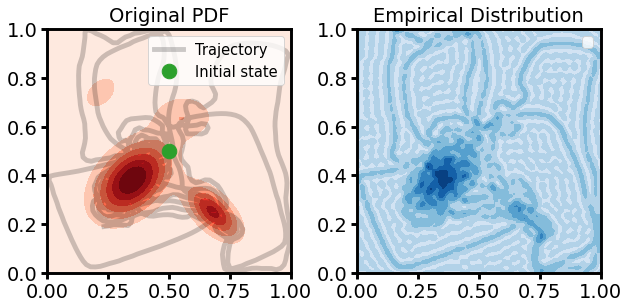

0.998201556317801 8.896009882972702
L2 distance: 0.011700
Total Variation: 0.414562
KL(p || q): 0.243008
KL(q || p): 2.107843
Jensen-Shannon: 0.184379
Cosine similarity: 0.841460


In [33]:
# reconstruct the emprical distribution
#phi_recon = np.zeros(grids.shape[0])
from scipy.spatial.distance import cdist
from numpy.linalg import solve
### Fourier
phi_recon = np.zeros(grids.shape[0])
for i, (k_vec, ck, hk) in enumerate(zip(ks, ck_list_update/(tsteps*dt), hk_list)):
    fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)
    fk_vals /= hk
    phi_recon += ck * fk_vals

### Indicator
# Compute basis functions
"""fks = np.zeros((grids.shape[0], len(ks)))
for i,_ in enumerate(ks):
    f1 = sig(grids,lower[i])
    f2 = sig(grids,upper[i])
    fks[:, i] = np.prod(f1 * (1 - f2), axis=-1)

# Compute Gram matrix and RHS vector
    
G = fks.T @ (fks * dx * dy)
# Solve for coefficients
c = np.linalg.solve(G + 1e-6 * np.eye(G.shape[0]), ck_list_update/(tsteps*dt))
phi_recon = fks @ c"""

### Radial
"""pairwise_dists = cdist(centers, centers)
G = (sigma * np.sqrt(np.pi))**centers.shape[1] * np.exp(-pairwise_dists**2 / (4 * sigma**2))
a = solve(G, ck_list_update/(tsteps*dt))
grid_dists = cdist(grids, centers) 
rbf_vals = np.exp(-grid_dists**2 / (2 * sigma**2)) 
phi_recon = rbf_vals @ a"""

"""## Multiple Radials
M = centers.shape[0]
N = sigmas.shape[0]
d = centers.shape[1]
pairwise_centers = cdist(centers, centers, 'sqeuclidean')  # shape (M, M)
G = np.zeros((M, M))
for i in range(N):
    for m in range(N):
        coef = (np.sqrt(np.pi) * np.sqrt(2 * sigmas[i]**2 * sigmas[m]**2 / (sigmas[i]**2 + sigmas[m]**2)))**d
        exp_term = np.exp(-pairwise_centers / (2 * (sigmas[i]**2 + sigmas[m]**2)))
        G += weights[i] * weights[m] * coef * exp_term
rhs = np.zeros(M)
for i in range(N):
    coef = (np.sqrt(np.pi) * np.sqrt(2) * sigmas[i])**d
    rhs += weights[i] * coef * ck_list_update / (tsteps * dt)
c = np.linalg.solve(G + 1e-6 * np.eye(M), rhs)

sq_dists = cdist(grids, centers, 'sqeuclidean')
rbf_vals = np.zeros((grids.shape[0], M))
for i in range(N):
    rbf_vals += weights[i] * np.exp(-sq_dists / (2 * sigmas[i]**2))

phi_recon = rbf_vals @ c
"""
# visualize the trajectory
fig, axes = plt.subplots(1, 2, figsize=(9,5), dpi=70, tight_layout=True)
#fig, axes = plt.subplots(figsize=(6, 4), dpi=100, tight_layout=True) #### For now only one plot as i do not wish to reconstruct.
ax = axes[0]
ax.set_aspect('equal')
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
ax.set_title('Original PDF')
ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='Reds')
ax.plot(x_traj[::10,0], x_traj[::10,1], linestyle='-', marker='', color='k', alpha=0.2, label='Trajectory')
ax.plot(x_traj[0,0], x_traj[0,1], linestyle='', marker='o', markersize=15, color='C2', alpha=1.0, label='Initial state')
ax.legend(loc=1)

ax = axes[1]
ax.set_aspect('equal')
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
ax.set_title('Empirical Distribution')
ax.contourf(grids_x, grids_y, phi_recon.reshape(grids_x.shape), cmap='Blues')
ax.legend(loc=1)
fig.tight_layout()
fig.subplots_adjust(top=0.9)  # adjust if title overlaps with subplots
#fig.suptitle(f"Radial basis with \sigma {sigmas[0][0]} on {num_k_per_dim}x{num_k_per_dim} Grid for {dt * tsteps} seconds", fontsize=16)
plt.show()
plt.close()

results = compare_pdfs(pdf_vals, phi_recon)
for name, value in results.items():
    print(f"{name}: {value:.6f}")



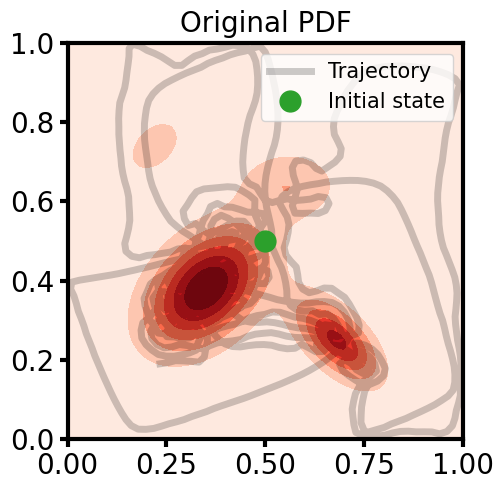

In [34]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=100, tight_layout=True)
ax.set_aspect('equal')
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
ax.set_title('Original PDF')
ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='Reds')
ax.plot(x_traj[::10,0], x_traj[::10,1], linestyle='-', marker='', color='k', alpha=0.2, label='Trajectory')
ax.plot(x_traj[0,0], x_traj[0,1], linestyle='', marker='o', markersize=15, color='C2', alpha=1.0, label='Initial state')
ax.legend(loc=1)

plt.show()
plt.close()

2025-08-12 15:49:51,427 |  WARNING | legend.py:1236 | No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


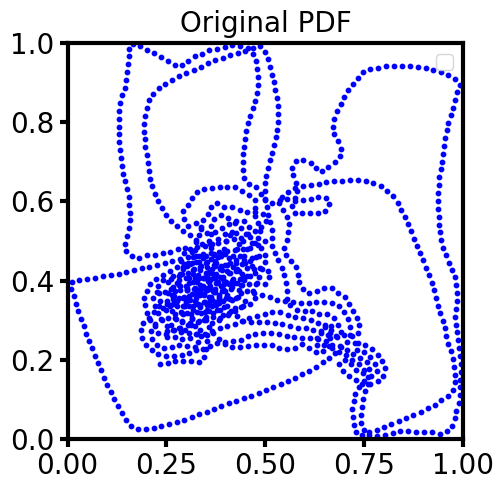

In [35]:
mu_samples = sample_from_density_2d(pdf_vals.reshape(num_grid, num_grid), grids_x, grids_y, n_samples = x_traj.shape[0])
fig, ax = plt.subplots(figsize=(6, 5), dpi=100, tight_layout=True)
ax.set_aspect('equal')
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
ax.set_title('Original PDF')
#ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='Reds')
ax.scatter(x_traj[::10, 0], x_traj[::10, 1], s=10, color='blue')
#ax.scatter(mu_samples[::10, 0], mu_samples[::10, 1], s=10, color='green')
ax.legend(loc=1)
plt.show()
plt.close()

In [36]:
import infomeasure as im
mu_samples = sample_from_density_2d(pdf_vals.reshape(num_grid, num_grid), grids_x, grids_y, n_samples = x_traj.shape[0])
mu_samples_test = sample_from_density_2d(pdf_vals.reshape(num_grid, num_grid), grids_x, grids_y, n_samples = x_traj.shape[0])
print(im.kld(x_traj,mu_samples, approach='metric'), 'emp')
#print(im.kld(x_traj,mu_samples, approach='renyi', alpha=0.8), 'emp')
#print(im.kld(x_traj,mu_samples, approach='tsallis', q=0.8), 'emp')
print(im.kld(mu_samples_test,mu_samples, approach='metric'), 'opt')
#print(im.kld(mu_samples_test,mu_samples, approach='renyi', alpha=0.8), 'opt')
#print(im.kld(mu_samples_test,mu_samples, approach='tsallis', q=0.8), 'opt')


1.936922100321694 emp
-0.10991075987386267 opt


In [37]:
from scipy.stats import gaussian_kde
def sanov_upper_bound(f, pdf, bandwidth='silverman'):
    """
    Compute Sanov's upper bound on the probability that the empirical distribution of f
    comes from a distribution with density pdf.

    Parameters:
    - f: np.ndarray, shape (n_samples, d), the sample points
    - pdf: callable, function that accepts f[i] and returns pdf(x)
    - bandwidth: str or float, bandwidth method for KDE

    Returns:
    - kl_estimate: float, D_KL(empirical || pdf)
    - bound: float, upper bound on probability under Sanov
    """

    n_samples, d = f.shape

    # Estimate empirical distribution using KDE
    kde_empirical = gaussian_kde(f.T, bw_method=bandwidth)

    # Evaluate densities at sample points
    p_vals = kde_empirical(f.T) + 1e-12  # empirical density
    q_vals = pdf(f) + 1e-12            # model density

    # KL divergence estimate
    kl_estimate = np.mean(np.log(p_vals / q_vals))

    # Sanov upper bound
    bound = np.exp(-n_samples * kl_estimate)

    return kl_estimate, bound

#kl, bound = sanov_upper_bound(x_traj, pdf)
#print(f"Estimated KL divergence: {kl:.6f}")
#print(f"Sanov upper bound: {bound:.2e}")
#mu_samples = sample_from_density_2d(pdf_vals.reshape(num_grid, num_grid), grids_x, grids_y, n_samples = x_traj.shape[0])
#kl, bound = sanov_upper_bound(mu_samples, pdf)
#print(f"Optimal Estimated KL divergence: {kl:.6f}")
#print(f"Optimal Sanov upper bound: {bound:.2e}")

In [38]:
import numpy as np
from scipy.special import rel_entr  # for KL divergence

def empirical_distribution(samples, alphabet):
    counts = np.array([np.sum(samples == a) for a in alphabet])
    return counts / len(samples)

def kl_divergence(p, q):
    p = np.asarray(p, dtype=np.float64)
    q = np.asarray(q, dtype=np.float64)
    return np.sum(rel_entr(p, q))  # rel_entr = p * log(p/q)

def sanov_bound(samples, q, alphabet):
    """
    Upper bound on the probability that empirical distribution deviates from q.

    Parameters:
    - samples: array of observed symbols (from alphabet)
    - q: true distribution over alphabet (list or np.array)
    - alphabet: list of symbols in the support

    Returns:
    - bound: Sanov upper bound
    - kl: KL divergence between empirical and q
    """
    n = len(samples)
    k = len(alphabet)

    # Empirical distribution from samples
    p_hat = empirical_distribution(samples, alphabet)

    # KL divergence D(p_hat || q)
    kl = kl_divergence(p_hat, q)

    # Polynomial correction (number of types over k symbols)
    correction = (n + 1)**k

    # Sanov bound
    bound = correction * 2**(-n * kl)

    return bound, kl

mu_samples = sample_from_density_2d(pdf_vals.reshape(num_grid, num_grid), grids_x, grids_y, n_samples = x_traj.shape[0])
#bound, kl = sanov_bound(x_traj, mu_samples, alphabet)
#print(f"Sanov upper bound: {bound:.3e}")
#print(f"KL divergence: {kl:.6f}")

In [39]:
def sanov_upper_bound(f, pdf):
    """
    Compute Sanov's upper bound on the probability that the empirical distribution of `f`
    deviates from a reference distribution with density `pdf`.

    Parameters:
    - f: np.ndarray, shape (n_samples, d), the sample points
    - pdf: callable, function that accepts f (N,d) and returns p(x) as (N,) array

    Returns:
    - kl_estimate: float, D_KL(empirical || pdf)
    - bound: float, Sanov upper bound on the probability
    """

    n_samples = f.shape[0]

    # Evaluate target PDF at sample points (theoretical p(x))
    p_vals = pdf(f)  # avoid log(0) — ensure strictly > 0

    # Empirical density puts 1/n mass at each point => KL(empirical || pdf)
    kl_estimate = np.log(n_samples) - np.mean(np.log(p_vals))

    # Sanov bound: P(empirical ≈ f) ≤ exp(-n * D_KL)
    bound = np.exp(-n_samples * kl_estimate)

    return kl_estimate, bound

#kl, bound = sanov_upper_bound(x_traj, pdf)
#print(f"Estimated KL divergence: {kl:.6f}")
#print(f"Sanov upper bound: {bound:.2e}")
#mu_samples = sample_from_density_2d(pdf_vals.reshape(num_grid, num_grid), grids_x, grids_y, n_samples = x_traj.shape[0])
#kl, bound = sanov_upper_bound(mu_samples, pdf)
#print(f"Optimal Estimated KL divergence: {kl:.6f}")
#print(f"Optimal Sanov upper bound: {bound:.2e}")


In [40]:
mu_samples = sample_from_density_2d(pdf_vals.reshape(num_grid, num_grid), grids_x, grids_y, n_samples = x_traj.shape[0])
optimal = np.sum(np.log(pdf(mu_samples)))
samples = np.sum(np.log(pdf(x_traj)))

In [41]:
print(optimal, samples)

10885.98283862934 -5035.93398789956


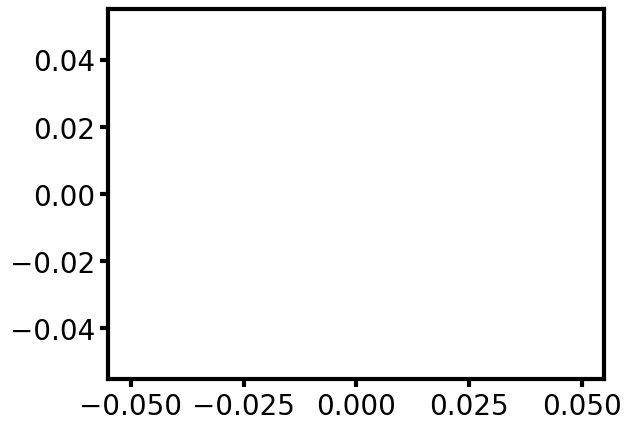

In [42]:
plt.plot(Wasserstein)
plt.show()

In [43]:
### Make sure to change the filename here!
#import json
#with open(r'eval_data/Indicator.json', 'w') as f:
#    json.dump(results_indicator, f)

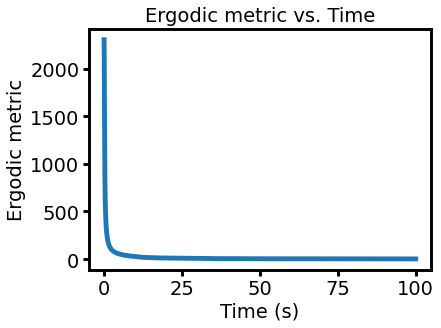

In [44]:
# Also visualize the ergodic metric over time
fig, ax = plt.subplots(1, 1, dpi=70, tight_layout=True)

ax.plot(np.arange(tsteps)*dt, metric_log)
ax.set_title('Ergodic metric vs. Time')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Ergodic metric')

plt.show()
plt.close()

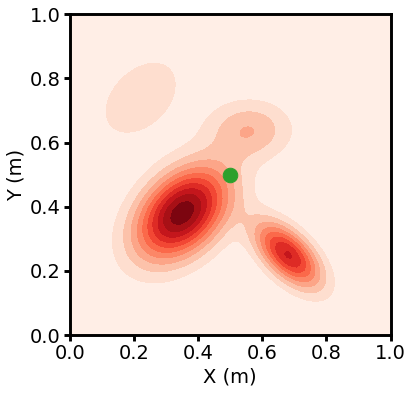

In [45]:
# Generate animation (takes about 1 minute)
from IPython.display import HTML
from matplotlib import animation

fig, ax = plt.subplots(1, 1, figsize=(6,7), dpi=70, tight_layout=True)
ax.set_aspect('equal')
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='Reds', levels=10)

robot_traj, = ax.plot([], [], linestyle='-', marker='', color='k', alpha=0.2)
robot_state, = ax.plot(x_traj[0,0], x_traj[0,1], linestyle='', marker='o', markersize=15, color='C2')

def update_plot(frame):
    t = int(frame * 20)
    robot_state.set_data(
        np.array([x_traj[t][0]]), np.array([x_traj[t][1]])
    )
    robot_traj.set_data(
        x_traj[:t,0][::20], x_traj[:t,1][::20]
    )

    return robot_state, robot_traj,

#ani = animation.FuncAnimation(fig, update_plot, frames=int(tsteps/20)-1, blit=True, interval=30, repeat=False)
#video = ani.to_html5_video()
#HTML(video)